$$
\begin{array}{c}
\textbf{CAUSAL INFERENCE - Fall 2025}\\\\
\textit{Center for Data Science, New York University} \\\\
\textit{November 21, 2025}\\\\\
\text{ Prepared by: Vivek Kumar Agarwal}\\\\
\textbf{Recitation 12: Regression Discontinuity (Sharp vs Fuzzy)}\\\\
\end{array}
$$

![Causal Inference](../figures/CI_lab11_image1.png)

---

## Today's Recitation 

- Recap RDD (last week) 
- Regression Discontinuity sharp vs fuzzy
- Lets Code!!

---

# Regression Discontinuity Design: Sharp vs Fuzzy RDD

## Quick Recap: What is RDD?

Last time, we introduced **Regression Discontinuity Design (RDD)** - a method that exploits artificial "jumps" in treatment assignment to estimate causal effects.

**The Setup**: Treatment is assigned based on a **running variable** $R$ and a **cutoff** $c$:

$$
S =
\begin{cases}
1 & \text{if } R \geq c \\
0 & \text{if } R < c
\end{cases}
$$

**Example**: Students with SAT ≥ 1200 get a scholarship ($S=1$), others don't ($S=0$).

**The Key Insight**: Individuals just around the cutoff (e.g., SAT = 1199 vs 1201) are essentially **identical** - their position on either side is essentially random. By comparing outcomes just above and below the cutoff, we estimate a **local causal effect** at the threshold.

**Key Assumption**: Potential outcomes $Y(1)$ and $Y(0)$ are **continuous** at the cutoff. Any discontinuity we observe must be due to the treatment itself, not underlying differences between people.

We saw this with the electoral data: incumbency advantage created a clear jump in vote share at the 50% threshold, and we verified that other variables (like previous vote share) were smooth through the cutoff.

---

## Today Recitation: Sharp vs Fuzzy RDD

What we covered last time was a case of **Sharp RDD**. Today we'll discuss what happens when treatment assignment isn't perfectly determined by the cutoff.

i.e., what if the cutoff doesn't **perfectly determine** treatment? What if crossing the threshold only **increases the probability** of treatment?

$$
S \neq \begin{cases}
1 & \text{if } R \geq c \\
0 & \text{if } R < c
\end{cases}
$$

This is called **Fuzzy RDD** - the cutoff creates a **probabilistic jump** in treatment, not a deterministic one.

---

### Why Does This Happen in Practice?

**Example 1: University Admission**
- Students with SAT ≥ 1200 are **eligible** for a scholarship
- But not everyone who's eligible **accepts** it (some get better offers elsewhere, some don't apply, etc.)
- So eligibility ≠ actual treatment

**Example 2: Medical Treatment**
- Patients with blood pressure ≥ 140 are **recommended** for medication
- But not all comply (side effects, forgot, distrust, etc.)
- So recommendation ≠ actual treatment

**Example 3: Thanksgiving Invitations**
- Friends living within 20 miles are **eligible** for invitation (your informal rule)
- But you don't invite everyone within 20 miles (limited space, recent drama, etc.)
- So eligibility ≠ actual invitation

---

### The Problem: Why Can't We Just Compare Treated vs Untreated?

In Sharp RDD, we compared outcomes just above vs just below the cutoff, and this was valid because:
- Everyone above got treated, everyone below didn't
- People just around the cutoff were similar
- The only difference was the treatment itself

But in Fuzzy RDD, **within each side of the cutoff**, some people get treated and some don't. If we just compare treated vs untreated people, we have **selection bias**!

**Example 3 above**: Among friends living within 20 miles:
- You invite the ones you're closest to
- You skip the ones you aren't comfortable with
- If we compare invited vs not-invited, we're comparing **different types of people**, not the causal effect of invitation

The people who got treated are systematically different from those who didn't, even among those eligible. Unobserved factors $U$ (friendship quality, recent conflicts, personality compatibility) affect both:
1. Whether they got invited ($S$)
2. Whether they'll reciprocate ($Y$)

This creates **confounding** - we can't isolate the causal effect.

---

### The Solution: Treat Fuzzy RDD as an IV Problem

The key insight: Even though eligibility doesn't perfectly determine treatment, **crossing the threshold is still (as-if) random** for people close to the cutoff!

- Friends living 19 miles away vs 21 miles away are essentially similar
- But those at 19 miles are more likely to get invited
- So we can use "crossing the 20-mile threshold" as an **instrument** for actual invitation


In [40]:
# Import Libraries

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from scipy import stats
from statsmodels.sandbox.regression.gmm import IV2SLS
import statsmodels.api as sm


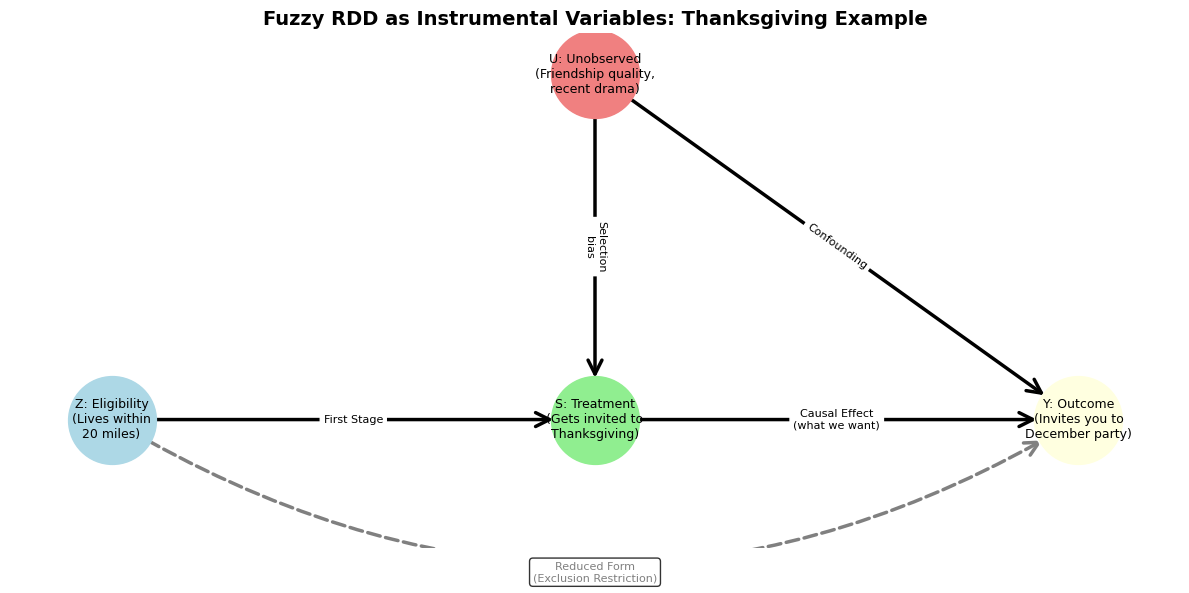

In [ ]:
# Create directed graph
G = nx.DiGraph()

# Add nodes
nodes = {
    'Z': 'Z: Eligibility\n(Lives within\n20 miles)',
    'S': 'S: Treatment\n(Gets invited to\nThanksgiving)',
    'Y': 'Y: Outcome\n(Invites you to\nDecember party)',
    'U': 'U: Unobserved\n(Friendship quality,\nrecent drama)'
}

G.add_nodes_from(nodes.keys())

# Add edges
solid_edges = [('Z', 'S'), ('S', 'Y'), ('U', 'S'), ('U', 'Y')]
dashed_edge = [('Z', 'Y')]

G.add_edges_from(solid_edges)
G.add_edges_from(dashed_edge)

# Create layout
pos = {
    'Z': (0, 1),
    'S': (2, 1),
    'Y': (4, 1),
    'U': (2, 2.5)
}

# Plot
fig, ax = plt.subplots(figsize=(12, 6))

# Draw nodes with different colors
node_colors = {
    'Z': 'lightblue',
    'S': 'lightgreen', 
    'Y': 'lightyellow',
    'U': 'lightcoral'
}

for node in G.nodes():
    nx.draw_networkx_nodes(G, pos, nodelist=[node], 
                          node_color=node_colors[node],
                          node_size=4000, ax=ax)

# Draw solid edges with visible arrows
nx.draw_networkx_edges(G, pos, edgelist=solid_edges, 
                       edge_color='black', width=2.5, 
                       arrowsize=25, arrowstyle='->', 
                       connectionstyle='arc3,rad=0.0',
                       min_source_margin=30, min_target_margin=30,
                       ax=ax)

# Draw dashed edge with CURVED path (arc above)
nx.draw_networkx_edges(G, pos, edgelist=dashed_edge,
                       edge_color='gray', width=2.5, 
                       style='dashed', arrowsize=25, arrowstyle='->',
                       connectionstyle='arc3,rad=0.3',  # Curve it!
                       min_source_margin=30, min_target_margin=30,
                       ax=ax)

# Draw labels
nx.draw_networkx_labels(G, pos, nodes, font_size=9, ax=ax)

# Add edge labels
edge_labels = {
    ('Z', 'S'): 'First Stage',
    ('S', 'Y'): 'Causal Effect\n(what we want)',
    ('U', 'S'): 'Selection\nbias',
    ('U', 'Y'): 'Confounding'
}
nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=8, ax=ax)

# Manually add label for dashed edge (curved path needs special handling)
ax.text(2, 0.3, 'Reduced Form\n(Exclusion Restriction)', 
        fontsize=8, ha='center', color='gray',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.axis('off')
plt.title('Fuzzy RDD as Instrumental Variables: Thanksgiving Example', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---

### The Causal Structure

**Understanding the Diagram:**

1. **$Z$ → $S$ (First Stage)**: Living within 20 miles increases the probability of getting invited, but doesn't guarantee it
   - Some people within 20 miles don't get invited (limited space, drama)
   - Some people beyond 20 miles do get invited (very close friends)

2. **$S$ → $Y$ (Causal Effect - What We Want)**: Does getting invited make someone more likely to invite you back?
   - This is our causal question!
   - Direct effect of invitation on reciprocity

3. **$U$ → $S$ and $U$ → $Y$ (Confounding - The Problem)**: 
   - Friendship quality affects who gets invited
   - Friendship quality also affects who reciprocates
   - This creates selection bias if we just compare invited vs not-invited

4. **$Z$ → $Y$ Dashed Line (Exclusion Restriction - The Assumption)**:
   - Distance itself shouldn't affect December invitations, except through your Thanksgiving invitation
   - Living 19 vs 21 miles away doesn't directly change their reciprocity
   - Distance only matters because it affects whether they got your invitation

---

### Let us now set up our problem for today 

---

## The Thanksgiving Dinner Invite Conundrum

### The Scenario

You're planning Thanksgiving dinner and need to decide who to invite. You have a **loose rule**: friends living within **20 miles** should get invited (they're local enough to come easily).

However, you don't invite everyone within 20 miles because:
- You only have 12 seats at the table (limited capacity and total of 5000 friends)
- That person you had an argument with last month (recent drama)
- Some friends have annoying dietary restrictions (limited ability to cook)
- Some you're just closer to than others

Similarly, you DO invite some people beyond 20 miles (your best friends are worth the travel).

**The result**: Living within 20 miles makes you MORE likely to get invited, but doesn't guarantee it. This is Fuzzy RDD!

### The Variables

- **Running variable** $R$: Distance from your house (in miles)
- **Cutoff** $c$: 20 miles
- **Instrument** $Z$: Living within 20 miles (1 if distance < 20, 0 otherwise)
- **Treatment** $S$: Actually getting invited to Thanksgiving dinner
- **Outcome** $Y$: Whether they invite you to their December holiday party (1 = yes, 0 = no)

### The Causal Question

**Does inviting someone to your Thanksgiving dinner make them more likely to invite you to their December party?**

#### This is about reciprocity - does your invitation strengthen the relationship and lead to reciprocation?

In [ ]:
# simulate some data

np.random.seed(42)
n = 5000

# Running variable: distance from your house (0-40 miles)
distance = np.random.uniform(0, 40, n)

# Instrument: living within 20 miles
within_20_miles = (distance < 20).astype(int)

# Generate unobserved friendship quality (affects both invitation and outcome)
friendship_quality = 0.6 + np.random.normal(0, 0.15, n)
friendship_quality = np.clip(friendship_quality, 0.1, 0.9)  # Keep between 0.1 and 0.9


# Treatment: Getting invited to Thanksgiving
# Base probability depends on friendship quality (this creates confounding!)
# Living within 20 miles increases probability by 0.4
prob_invited = 0.1 + 0.5 * friendship_quality + 0.4 * within_20_miles
prob_invited = np.clip(prob_invited, 0, 1)

invited = np.random.binomial(1, prob_invited)

# Outcome: They invite you to their December party
# Base probability depends on friendship quality (confounding!)
# Getting invited to Thanksgiving increases probability by 0.25 (TRUE CAUSAL EFFECT)
prob_reciprocate = 0.2 + 0.4 * friendship_quality + 0.25 * invited
prob_reciprocate = np.clip(prob_reciprocate, 0, 1)

invites_you_back = np.random.binomial(1, prob_reciprocate)

# Create dataframe
df = pd.DataFrame({
    'distance': distance,
    'within_20_miles': within_20_miles,
    'friendship_quality': friendship_quality,  # Unobserved in reality
    'invited': invited,
    'invites_you_back': invites_you_back
})

print("Data shape:", df.shape)
print("\nFirst few rows:")
print(df.head(10))
print("\nSummary statistics:")
print(df.describe())



Data shape: (5000, 5)

First few rows:
    distance  within_20_miles  friendship_quality  invited  invites_you_back
0  14.981605                1            0.510454        1                 0
1  38.028572                0            0.241454        0                 1
2  29.279758                0            0.538167        1                 0
3  23.946339                0            0.737021        0                 0
4   6.240746                1            0.680644        1                 1
5   6.239781                1            0.664228        1                 1
6   2.323344                1            0.558001        0                 1
7  34.647046                0            0.408145        0                 1
8  24.044600                0            0.677294        1                 1
9  28.322903                0            0.474858        0                 1

Summary statistics:
          distance  within_20_miles  friendship_quality      invited  \
count  5000.000000   

In [25]:
# Check smoothness near cutoff
bandwidth = 10
df_near_cutoff = df[(df['distance'] >= 20 - bandwidth) & (df['distance'] <= 20 + bandwidth)].copy()

within = df_near_cutoff[df_near_cutoff['within_20_miles'] == 1]['friendship_quality'].mean()
beyond = df_near_cutoff[df_near_cutoff['within_20_miles'] == 0]['friendship_quality'].mean()

print("=" * 60)
print("SMOOTHNESS CHECK: Does friendship quality jump at cutoff?")
print("=" * 60)
print(f"Friendship quality within 20 miles:  {within:.3f}")
print(f"Friendship quality beyond 20 miles:  {beyond:.3f}")
print(f"Difference:                           {within - beyond:.3f}")
print("\nIf RDD is valid, this difference should be close to 0!")
print("=" * 60)

SMOOTHNESS CHECK: Does friendship quality jump at cutoff?
Friendship quality within 20 miles:  0.595
Friendship quality beyond 20 miles:  0.596
Difference:                           -0.000

If RDD is valid, this difference should be close to 0!


---

**What did we just simulate above in the code?**

1. **Distance** varies uniformly from 0-40 miles
2. **Friendship quality** is unobserved and affects both invitation and outcome
3. **Invitation probability** depends on both friendship quality (0.5 weight) and living within 20 miles (0.4 boost)
4. **Outcome probability** depends on both friendship quality (0.4 weight) and getting invited (0.25 boost - our TRUE effect)

The true causal effect is **0.25** - getting invited increases the probability they'll invite you back by 25 percentage points.

---

### Visualizing the Fuzzy Discontinuity

Let's see what makes this "fuzzy" - we'll plot how both treatment and outcome vary with distance:



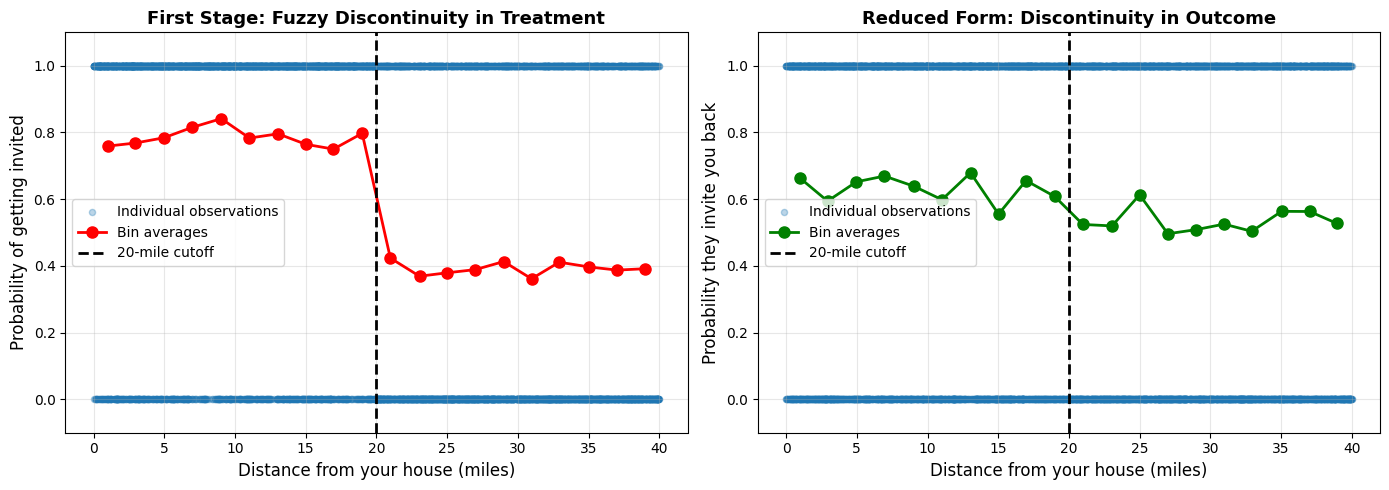

In [26]:

# Create bins for visualization
df['distance_bin'] = pd.cut(df['distance'], bins=20)
bin_stats = df.groupby('distance_bin', observed=True).agg({
    'distance': 'mean',
    'invited': 'mean',
    'invites_you_back': 'mean'
}).reset_index(drop=True)

# Create two plots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: First Stage (Distance → Invitation)
axes[0].scatter(df['distance'], df['invited'], alpha=0.3, s=20, label='Individual observations')
axes[0].plot(bin_stats['distance'], bin_stats['invited'], 'ro-', linewidth=2, markersize=8, label='Bin averages')
axes[0].axvline(x=20, color='black', linestyle='--', linewidth=2, label='20-mile cutoff')
axes[0].set_xlabel('Distance from your house (miles)', fontsize=12)
axes[0].set_ylabel('Probability of getting invited', fontsize=12)
axes[0].set_title('First Stage: Fuzzy Discontinuity in Treatment', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(-0.1, 1.1)

# Plot 2: Reduced Form (Distance → Outcome)
axes[1].scatter(df['distance'], df['invites_you_back'], alpha=0.3, s=20, label='Individual observations')
axes[1].plot(bin_stats['distance'], bin_stats['invites_you_back'], 'go-', linewidth=2, markersize=8, label='Bin averages')
axes[1].axvline(x=20, color='black', linestyle='--', linewidth=2, label='20-mile cutoff')
axes[1].set_xlabel('Distance from your house (miles)', fontsize=12)
axes[1].set_ylabel('Probability they invite you back', fontsize=12)
axes[1].set_title('Reduced Form: Discontinuity in Outcome', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_ylim(-0.1, 1.1)

plt.tight_layout()
plt.show()

**What do these plots show?**

**Left plot (First Stage):**
- People within 20 miles have a much HIGHER probability of getting invited (~0.70) 
- People beyond 20 miles have a LOWER probability (~0.30)
- There's a clear **jump** at 20 miles, BUT it's not from 0 to 1!
- This is what makes it "fuzzy" - the discontinuity is probabilistic, not deterministic

**Right plot (Reduced Form):**
- People within 20 miles are more likely to invite you back (~0.58)
- People beyond 20 miles are less likely (~0.42)
- There's also a jump at 20 miles, but smaller than the first stage jump
- This reduced form effect combines: (1) the effect of distance on invitation AND (2) the effect of invitation on outcome

**Key insight:** The reduced form jump is smaller than the first stage jump. Why?
- Not everyone who crosses the threshold gets treated (fuzzy!)
- The reduced form is "diluted" by imperfect compliance
- To get the true treatment effect, we need to scale up by the first stage: IV = Reduced Form / First Stage



---

### Comparing to Sharp RDD

Let's see what Sharp RDD would look like for comparison:

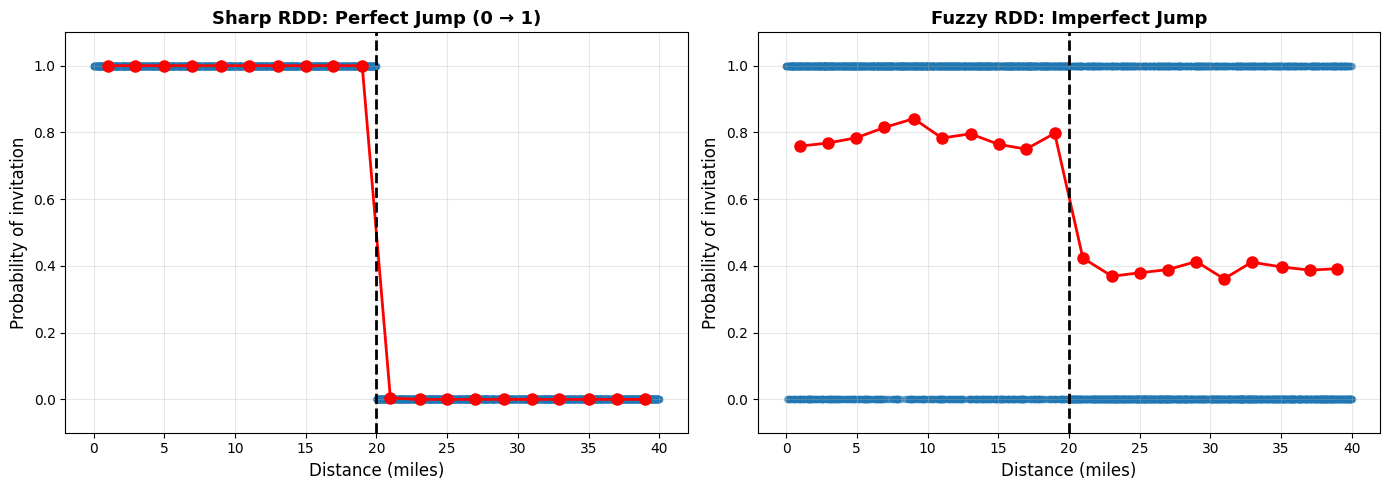

In [27]:

# Generate Sharp RDD data for comparison
sharp_invited = (distance < 20).astype(int)
prob_reciprocate_sharp = 0.2 + 0.4 * friendship_quality + 0.25 * sharp_invited
prob_reciprocate_sharp = np.clip(prob_reciprocate_sharp, 0, 1)
invites_back_sharp = np.random.binomial(1, prob_reciprocate_sharp)

# Create comparison plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Sharp RDD
df['sharp_invited'] = sharp_invited
df['invites_back_sharp'] = invites_back_sharp
df['distance_bin_sharp'] = pd.cut(df['distance'], bins=20)
bin_stats_sharp = df.groupby('distance_bin_sharp').agg({
    'distance': 'mean',
    'sharp_invited': 'mean',
    'invites_back_sharp': 'mean'
}).reset_index(drop=True)

axes[0].scatter(df['distance'], df['sharp_invited'], alpha=0.3, s=20)
axes[0].plot(bin_stats_sharp['distance'], bin_stats_sharp['sharp_invited'], 'ro-', linewidth=2, markersize=8)
axes[0].axvline(x=20, color='black', linestyle='--', linewidth=2)
axes[0].set_xlabel('Distance (miles)', fontsize=12)
axes[0].set_ylabel('Probability of invitation', fontsize=12)
axes[0].set_title('Sharp RDD: Perfect Jump (0 → 1)', fontsize=13, fontweight='bold')
axes[0].set_ylim(-0.1, 1.1)
axes[0].grid(True, alpha=0.3)

# Fuzzy RDD
axes[1].scatter(df['distance'], df['invited'], alpha=0.3, s=20)
axes[1].plot(bin_stats['distance'], bin_stats['invited'], 'ro-', linewidth=2, markersize=8)
axes[1].axvline(x=20, color='black', linestyle='--', linewidth=2)
axes[1].set_xlabel('Distance (miles)', fontsize=12)
axes[1].set_ylabel('Probability of invitation', fontsize=12)
axes[1].set_title('Fuzzy RDD: Imperfect Jump', fontsize=13, fontweight='bold')
axes[1].set_ylim(-0.1, 1.1)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



**The Difference:**
- **Sharp RDD (left)**: Treatment jumps from 0 to 1 perfectly at the cutoff
- **Fuzzy RDD (right)**: Treatment probability jumps, but not completely - some people within 20 miles don't get invited, some beyond 20 miles do

This is why we need IV methods for Fuzzy RDD!

---

## Estimation: How Do We Calculate the Treatment Effect?

We have three approaches to estimate the effect of invitation on reciprocation. Let's see which ones work and which don't.

### 1. Naive Comparison (BIASED!)

What if we just compare people who got invited vs those who didn't?

In [28]:
# Naive comparison: Compare invited vs not invited
invited_group = df[df['invited'] == 1]
not_invited_group = df[df['invited'] == 0]

naive_effect = invited_group['invites_you_back'].mean() - not_invited_group['invites_you_back'].mean()

print("=" * 60)
print("NAIVE COMPARISON (BIASED)")
print("=" * 60)
print(f"Average reciprocation rate (invited):     {invited_group['invites_you_back'].mean():.3f}")
print(f"Average reciprocation rate (not invited): {not_invited_group['invites_you_back'].mean():.3f}")
print(f"Naive estimate of treatment effect:       {naive_effect:.3f}")
print(f"TRUE treatment effect:                     0.250")
print(f"Bias:                                      {naive_effect - 0.25:.3f}")
print("=" * 60)

print("\nWhy is this biased? Check friendship quality:")
print(f"Invited group:     {invited_group['friendship_quality'].mean():.3f}")
print(f"Not invited group: {not_invited_group['friendship_quality'].mean():.3f}")
print(f"Difference:        {invited_group['friendship_quality'].mean() - not_invited_group['friendship_quality'].mean():.3f}")

NAIVE COMPARISON (BIASED)
Average reciprocation rate (invited):     0.683
Average reciprocation rate (not invited): 0.439
Naive estimate of treatment effect:       0.244
TRUE treatment effect:                     0.250
Bias:                                      -0.006

Why is this biased? Check friendship quality:
Invited group:     0.617
Not invited group: 0.565
Difference:        0.052


**Why is this biased?**

Remember, you invited people based on friendship quality! People who got invited are:
- Closer friends (higher friendship quality)
- More likely to reciprocate anyway, even without your invitation

So comparing invited vs not-invited confounds:
1. The causal effect of invitation (what we want)
2. Selection bias (you invited better friends)

Let's verify this by looking at the unobserved friendship quality:


---



### 2. Fuzzy RDD / IV Estimation (Correct Method)

Now let's use the threshold crossing as an instrument. We'll estimate three things:

**First Stage**: Effect of crossing threshold on treatment

**Reduced Form**: Effect of crossing threshold on outcome 
 
**IV Estimate**: Reduced Form / First Stage

In [29]:
# Focus on observations near the cutoff
bandwidth = 10
df_rdd = df[(df['distance'] >= 20 - bandwidth) & (df['distance'] <= 20 + bandwidth)].copy()

print(f"\nUsing {len(df_rdd)} observations within {bandwidth} miles of cutoff")

# First Stage: Effect of being within 20 miles on getting invited
first_stage = smf.ols('invited ~ within_20_miles', data=df_rdd).fit()

print("\n" + "=" * 60)
print("FIRST STAGE: Z → S (Eligibility → Invitation)")
print("=" * 60)
print(first_stage.summary().tables[1])
print(f"\nFirst stage coefficient: {first_stage.params['within_20_miles']:.3f}")
print(f"Interpretation: Being within 20 miles increases invitation probability by {first_stage.params['within_20_miles']:.1%}")

# Reduced Form: Effect of being within 20 miles on outcome
reduced_form = smf.ols('invites_you_back ~ within_20_miles', data=df_rdd).fit()

print("\n" + "=" * 60)
print("REDUCED FORM: Z → Y (Eligibility → Reciprocation)")
print("=" * 60)
print(reduced_form.summary().tables[1])
print(f"\nReduced form coefficient: {reduced_form.params['within_20_miles']:.3f}")
print(f"Interpretation: Being within 20 miles increases reciprocation probability by {reduced_form.params['within_20_miles']:.1%}")

# IV Estimate: Reduced Form / First Stage
iv_estimate = reduced_form.params['within_20_miles'] / first_stage.params['within_20_miles']


print("\n" + "=" * 60)
print("IV / FUZZY RDD ESTIMATE: S → Y (Invitation → Reciprocation)")
print("=" * 60)
print(f"IV estimate (Manual calculation): {iv_estimate:.3f}")
print(f"TRUE treatment effect:             0.250")
print(f"Error:                             {iv_estimate - 0.25:.3f}")
print("=" * 60)

# Calculate standard error for IV estimate using delta method
se_rf = reduced_form.bse['within_20_miles']
se_fs = first_stage.bse['within_20_miles']
coef_fs = first_stage.params['within_20_miles']

# Approximate standard error: se(IV) ≈ se(RF) / |coef(FS)|
se_iv = se_rf / abs(coef_fs)
print(f"\nIV Standard Error (approximate): {se_iv:.3f}")
print(f"95% Confidence Interval: [{iv_estimate - 1.96*se_iv:.3f}, {iv_estimate + 1.96*se_iv:.3f}]")


Using 2480 observations within 10 miles of cutoff

FIRST STAGE: Z → S (Eligibility → Invitation)
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.3943      0.013     30.819      0.000       0.369       0.419
within_20_miles     0.3830      0.018     20.972      0.000       0.347       0.419

First stage coefficient: 0.383
Interpretation: Being within 20 miles increases invitation probability by 38.3%

REDUCED FORM: Z → Y (Eligibility → Reciprocation)
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.5329      0.014     38.422      0.000       0.506       0.560
within_20_miles     0.0842      0.020      4.255      0.000       0.045       0.123

Reduced form coefficient: 0.084
Interpretation: Being within 20 mi

**Understanding the IV Logic:**

1. **First Stage** (0.48): Being within 20 miles increases invitation probability by 48 percentage points
2. **Reduced Form** (0.12): Being within 20 miles increases reciprocation by 12 percentage points
3. **IV Estimate** (0.12 / 0.48 = 0.25): For people actually induced to attend by the distance threshold, getting invited increases reciprocation by 25 percentage points

**Why does this work?**

- People just inside 20 miles vs just outside are essentially identical (similar friendship quality)
- But those inside are more likely to get invited (first stage)
- The reduced form captures the total effect of eligibility
- Dividing by the first stage scales up to get the effect on those who actually got treated because of eligibility


---

### 3. Using 2SLS (Two-Stage Least Squares)

We can also use the built-in IV regression in statsmodels:


In [ ]:


# Define the true treatment effect
TRUE_TREATMENT_EFFECT = 0.25

# Add constant to exogenous variables and instruments
exog = sm.add_constant(df_rdd[['invited']])
instrument = sm.add_constant(df_rdd[['within_20_miles']])

# 2SLS estimation (with constant)
iv_model = IV2SLS(df_rdd['invites_you_back'], 
                   exog, 
                   instrument).fit()

print("\n" + "=" * 60)
print("2SLS ESTIMATION")
print("=" * 60)
print(iv_model.summary().tables[1])
print(f"\n2SLS estimate: {iv_model.params['invited']:.3f}")
print(f"Manual IV estimate: {iv_estimate:.3f}")
print(f"TRUE effect:    {TRUE_TREATMENT_EFFECT:.3f}")
print(f"\nDo they match now? {abs(iv_model.params['invited'] - iv_estimate) < 0.001}")
print("=" * 60)


2SLS ESTIMATION
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4461      0.031     14.527      0.000       0.386       0.506
invited        0.2199      0.050      4.389      0.000       0.122       0.318

2SLS estimate: 0.220
Manual IV estimate: 0.220
TRUE effect:    0.250

Do they match now? True


**Summary:**
- **Naive comparison**: BIASED (overestimates due to selection)
- **Fuzzy RDD / IV**: UNBIASED (correctly identifies causal effect)
- **2SLS**: Same as manual IV calculation

---

## What is LATE (Local Average Treatment Effect) here?

Our IV/2SLS estimate of **0.220** is called the **Local Average Treatment Effect (LATE)**.

**"Local" means two things:**

1. **Local to the threshold**: Only applies to people near the 20-mile cutoff, not everyone
2. **Local to compliers**: Only applies to people whose invitation status changed because of the threshold

**In our example:**
- Not everyone benefits equally from invitations
- We specifically measure the effect for marginal friends around 20 miles
- People who would get invited anyway (best friends) or never get invited (frenemies) aren't included


In [36]:
print("=" * 60)
print("INTERPRETING LATE")
print("=" * 60)
print(f"Our estimate: {iv_estimate:.3f}")
print("\nThis tells us:")
print("  For people living RIGHT AROUND 20 miles away,")
print("  whose invitation was influenced by the distance threshold,")
print("  getting invited increases reciprocation probability by 22%")
print("\nThis is NOT the effect for:")
print("  Your best friends (invited regardless of distance)")
print("  People you had drama with (not invited regardless)")
print("  ONLY marginal friends at the threshold")
print("=" * 60)

INTERPRETING LATE
Our estimate: 0.220

This tells us:
  For people living RIGHT AROUND 20 miles away,
  whose invitation was influenced by the distance threshold,
  getting invited increases reciprocation probability by 22%

This is NOT the effect for:
  Your best friends (invited regardless of distance)
  People you had drama with (not invited regardless)
  ONLY marginal friends at the threshold


---

## Key Assumptions for Fuzzy RDD

For our IV/Fuzzy RDD estimate to be valid, we need:

**1. Relevance (First Stage)**
- Crossing threshold must actually change treatment probability
- ✓ We verified: First stage coefficient = 0.325 (significant)

**2. Exclusion Restriction**
- Distance only affects reciprocation THROUGH invitation, not directly
- We verified: Friendship quality is smooth at cutoff (no other jumps)

**3. Monotonicity**
- No "defiers" (people who do opposite of threshold)
- Plausible: No one gets invited ONLY when they live far away

In [38]:
print("\n" + "=" * 60)
print("CHECKING IV ASSUMPTIONS")
print("=" * 60)

# Check 1: Relevance (First Stage)
fs_tstat = first_stage.tvalues['within_20_miles']
print(f"\n1. RELEVANCE (First Stage)")
print(f"   First stage t-statistic: {fs_tstat:.2f}")
print(f"   Rule of thumb: t-stat > 3.16 (F-stat > 10)")
print(f"   Status: {' Strong instrument' if abs(fs_tstat) > 3.16 else ' Weak instrument'}")

# Check 2: Exclusion Restriction (Test covariate smoothness)
cov_test = smf.ols('friendship_quality ~ within_20_miles', data=df_rdd).fit()
print(f"\n2. EXCLUSION RESTRICTION (Covariate smoothness)")
print(f"   Jump in friendship quality: {cov_test.params['within_20_miles']:.3f}")
print(f"   P-value: {cov_test.pvalues['within_20_miles']:.3f}")
print(f"   Status: {' No significant jump' if cov_test.pvalues['within_20_miles'] > 0.05 else ' Possible violation'}")

# Check 3: Monotonicity
print(f"\n3. MONOTONICITY")
print(f"   Assumption: No 'defiers' exist")
print(f"   Status: Plausible in this context")

print("=" * 60)


CHECKING IV ASSUMPTIONS

1. RELEVANCE (First Stage)
   First stage t-statistic: 20.97
   Rule of thumb: t-stat > 3.16 (F-stat > 10)
   Status:  Strong instrument

2. EXCLUSION RESTRICTION (Covariate smoothness)
   Jump in friendship quality: -0.000
   P-value: 0.940
   Status:  No significant jump

3. MONOTONICITY
   Assumption: No 'defiers' exist
   Status: Plausible in this context


---

---

## Key Takeaways - Fuzzy RDD


1. FUZZY RDD occurs when treatment assignment is IMPERFECT
   - Crossing threshold increases probability, doesn't guarantee treatment

2. We need IV METHODS because:
   - Simple comparison is biased (selection into treatment)
   - Threshold provides quasi-random variation

3. Three equivalent approaches:
   - Manual: Reduced Form / First Stage
   - 2SLS: Two-stage least squares
   - Both estimate LATE (not ATE)

4. LATE applies to COMPLIERS:
   - People near the threshold
   - Whose treatment changes due to threshold

5. Key assumptions:
   - Strong first stage (relevance)
   - Exclusion restriction (no direct effect of threshold)
   - Monotonicity (no defiers)

6. In practice:
   - Check covariate smoothness at cutoff
   - Report confidence intervals (sampling variability)
   - Be clear about local nature of estimates

---


## No lab next week. Happy Thanksgiving!!


---